In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '../src')

In [3]:
import seaborn as sns
import vectorize

In [4]:
from fastai2 import *
from fastai2.text.all import *
import pandas as pd
import helpers

In [5]:
root_path = Path("Z:\\Hackathon 2019 #2_CSDA\\MIMIC-III Data")

# Context

## Electronic Medical Records and Coding

Health Information systems are used at a large scale in the healthcare institutions and hospitals for various tasks, such as medical record management, medical prescription, and billing. As a result, increasing large volumnes of healthcare data are regularly generated in form of Electronic medical records ( EMR ) . In this regard, textual data has a promiment place. 


One prominent task involves charcaterizing patient's hopsital stay (sympotons, diagnoses, treatments etc) by a small number of codes called **ICD 9 codes**


## ICD 9 Coding

ICD 9 coding system is based on WHO guidelines. One ICD-9 code indicates a classification of disease, diagnositc or treatment procedure, injury, sympton or information from patient history. Codes are structured hierarchically where top level categories are more generic ( e.g. neoplasm or disease in respiratory system ) and lower level codes indicate specific diseases ( e.g. breast cancer, pneumonia ). Higher level codes are only 3 digits while lower level codes are 4,5 digits with a decimal after 3rd digit. These codes are distributed such that a minority of the codes make up a majority of the distribution of label.

Because there are 6,198 codes our predictive power will be severly diminished for codes which do not often show up, We mapped all codes to their top level representation in the ICD-9, which level 19 top level ICD-9 codes 2b. 


## Discharge notes.
Length of the notes also vary which can create additional problem for modelling. Notes are also laden with medical jargon not common in other corpora, as well as misspellings.

# Data preparation from MIMIC database

### Notes

The MIMIC notes table contains all de-identify texts for patients and contain many type of reports (ECG, radio, nurse... ) . Among those only the discharge summary has been extracted

### ICD codes

TO guaranty representation of teh codes, prediction task will concern ICD categories ( level just upon the codes in the heirarchy) and only ICD categories that has atleast 1000 occurences have been selected

### Training & Test set

Among the 59,652 hospital admissions with both a discharge summary and ICD codes available. 51,300 have been selected based on code frquencies. Data was split into 41,453 annoted discharge summaries for training and 10,364 summaries for test

In [7]:
root_path.ls()

(#9) [Path('Z:/Hackathon 2019 #2_CSDA/MIMIC-III Data/DIAGNOSES_ICD.csv'),Path('Z:/Hackathon 2019 #2_CSDA/MIMIC-III Data/CPTEVENTS.csv'),Path('Z:/Hackathon 2019 #2_CSDA/MIMIC-III Data/ADMISSIONS.csv'),Path('Z:/Hackathon 2019 #2_CSDA/MIMIC-III Data/OUTPUTEVENTS.csv'),Path('Z:/Hackathon 2019 #2_CSDA/MIMIC-III Data/NOTEEVENTS.csv'),Path('Z:/Hackathon 2019 #2_CSDA/MIMIC-III Data/DRGCODES.csv'),Path('Z:/Hackathon 2019 #2_CSDA/MIMIC-III Data/Zipped'),Path('Z:/Hackathon 2019 #2_CSDA/MIMIC-III Data/PATIENTS.csv'),Path('Z:/Hackathon 2019 #2_CSDA/MIMIC-III Data/PROCEDURES_ICD.csv')]

In [8]:

df_note_events = pd.read_csv(root_path/'NOTEEVENTS.csv',dtype={'ROW_ID':np.int32, 'SUBJECT_ID': np.int32,'HADM_ID': str,
                                       'CHARTDATE':str,'STORETIME':str,'CHARTTIME':str,
                                       'STORETIME': str,'CATEGORY': str,'DESCRIPTION':str,'CGID':str,'ISERROR':str,
                                        'TEXT':str}, parse_dates=['CHARTDATE'])

df_diagnosis_icd = pd.read_csv(root_path/'DIAGNOSES_ICD.csv',dtype={'ROW_ID':np.int32, 'SUBJECT_ID': np.int32,'HADM_ID': str,
                                            'SEQ_NUM':  np.float64,'ICD9_CODE':str})

# Data Exploration

In [9]:
df_note_events.count()

ROW_ID         2083180
SUBJECT_ID     2083180
HADM_ID        1851344
CHARTDATE      2083180
CHARTTIME      1766614
STORETIME      1246404
CATEGORY       2083180
DESCRIPTION    2083180
CGID           1246404
ISERROR            886
TEXT           2083180
dtype: int64

In [10]:
df_note_events.groupby('CATEGORY').count()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,DESCRIPTION,CGID,ISERROR,TEXT
CATEGORY,,,,,,,,,,
Case Management,967,967,954,967,967,967,967,967,14,967
Consult,98,98,98,98,98,98,98,98,0,98
Discharge summary,59652,59652,59652,59652,0,0,59652,0,0,59652
ECG,209051,209051,138190,209051,0,0,209051,0,0,209051
Echo,45794,45794,34037,45794,0,0,45794,0,0,45794
General,8301,8301,8209,8301,8260,8301,8301,8301,65,8301
Nursing,223556,223556,220758,223556,222172,223556,223556,223556,374,223556
Nursing/other,822497,822497,821258,822497,822497,822497,822497,822497,0,822497
Nutrition,9418,9418,9378,9418,9411,9418,9418,9418,18,9418


# Explore DIAGNOSIS_ICD

In [11]:
df_diagnosis_icd['ICD9_CODE'].iloc[0]

'40301'

The code above let's you see the ICD-9 hierarchy and traverse it, getting the parents (path) of a node, the children of a node, siblings, etc. (well documented in its README file).

From looking at the top of the hierarchy, these are the ICD9-codes that are in the first level of the hierarchy.

* 001-139 INFECTIOUS AND PARASITIC DISEASES 
* 140-239 NEOPLASMS 
* 240-279 ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS 
* 290-319 MENTAL DISORDERS 
* 320-389 DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS 
* 390-459 DISEASES OF THE CIRCULATORY SYSTEM 
* 460-519 DISEASES OF THE RESPIRATORY SYSTEM 
* 520-579 DISEASES OF THE DIGESTIVE SYSTEM 
* 580-629 DISEASES OF THE GENITOURINARY SYSTEM 
* 630-679 COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM 
* 680-709 DISEASES OF THE SKIN AND SUBCUTANEOUS TISSUE 
* 710-739 DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE 
* 760-779 CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD 
* 780-789 SYMPTOMS 
* 790-796 NONSPECIFIC ABNORMAL FINDINGS 
* 797 Senility without mention of psychosis
* 798 Sudden death, cause unknown
* 799 Other ill-defined and unknown causes of morbidity and mortality
* 800-999 INJURY AND POISONING

The way that ICD9-codes are coded makes easy to find out which icd9-code code is the granparent in the first level, for example:

leave-code  code-at-first-level
* 64833    -> 630-679
* 4019     -> 390-459

The first three charachters of the leave icd9-code can be used to find out which is the grandparent icd-code in the first level

In [13]:
ICD9_FIRST_LEVEL = [
    '001-139','140-239','240-279','290-319', '320-389', '390-459','460-519', '520-579', '580-629', 
    '630-679', '680-709','710-739', '760-779', '780-789', '790-796', '797', '798', '799', '800-999' ]
N_TOP = len(ICD9_FIRST_LEVEL)

# replacing leave ICD9 codes with the grandparents
df_diagnosis_icd['ICD9_GRP'] = df_diagnosis_icd['ICD9_CODE'].apply(lambda x: helpers.replace_with_grandparent_codes(x,ICD9_FIRST_LEVEL))
df_diagnosis_icd.head(10)

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,ICD9_GRP
0,1297,109,172335,1.0,40301,390-459
1,1298,109,172335,2.0,486,460-519
2,1299,109,172335,3.0,58281,580-629
3,1300,109,172335,4.0,5855,580-629
4,1301,109,172335,5.0,4254,390-459
5,1302,109,172335,6.0,2762,240-279
6,1303,109,172335,7.0,7100,710-739
7,1304,109,172335,8.0,2767,240-279
8,1305,109,172335,9.0,7243,710-739
9,1306,109,172335,10.0,45829,390-459


In [17]:
# df_diagnosis_icd['ICD9_CODE'] = df_diagnosis_icd['ICD9_CODE'].str.pad(4,'left','0')
# df_diagnosis_icd['ICD9_GRP'] = df_diagnosis_icd['ICD9_CODE'].str.slice(0,3)
# df_diagnosis_icd.head()

# Exploration of diagnosis code to choose the target

### Selection of most frequent diagnosis codes

In [ ]:
a=df_diagnosis_icd.groupby('ICD9_CODE')['HADM_ID'].count().sort_values(ascending=False)
a.hist(figsize=(17, 5))

In [ ]:
np.log10(a).hist(figsize= (17, 5))


Due to sparsity in code distribution, we may need to look into the group codes.

In [ ]:
print('Nb codes > 1000 occurences= '+str(len(a[a>1000]))+
      '  \nNb codes 1000-100 occurences = ' +str(len(a[(a<1000)&(a>100)]))
      +'  \nNb codes <100 occurences = ' +str(len(a[a<100])) )

In [ ]:
a[a>1000].plot(kind='bar',figsize= (17, 10))


In [ ]:
a=df_diagnosis_icd.groupby('ICD9_CODE')[ 'HADM_ID'].count()
DIAGNOSES_ICD_freq=df_diagnosis_icd[df_diagnosis_icd['ICD9_CODE'].isin(a[a>1000].keys())]
df=DIAGNOSES_ICD_freq.groupby('HADM_ID')['ICD9_CODE'].apply(lambda x: "['%s']" %"','".join(x))
df=df.apply(lambda x : eval(x))
DIAGNOSES_ICD_freq=pd.DataFrame(df)
DIAGNOSES_ICD_freq['HADM_ID']=df.keys()
DIAGNOSES_ICD_freq.head()

In [ ]:
print("Total number of unique Admissions", DIAGNOSES_ICD_freq.HADM_ID.nunique())
print("Total number of unique ICD 9 codes", len(a[a>1000]))

### Selection of diagnosis code based on groups

In [14]:
count_icd_cases = df_diagnosis_icd.groupby('ICD9_GRP')['HADM_ID'].count().sort_values(ascending=False)

In [15]:
df=df_diagnosis_icd.groupby('HADM_ID')['ICD9_GRP'].apply(lambda x: "['%s']" %"','".join(x))
df=df.apply(lambda x : eval(x))
DIAGNOSES_ICD_grp_freq=pd.DataFrame(df)
DIAGNOSES_ICD_grp_freq['HADM_ID']=df.keys()
DIAGNOSES_ICD_grp_freq.head()

,ICD9_GRP,HADM_ID
HADM_ID,,
100001,"[240-279, 320-389, 580-629, 520-579, , 240-279, 520-579, 390-459, 240-279, 390-459, 580-629, 240-279, 320-389, 240-279, 680-709, ]",100001
100003,"[520-579, 290-319, 001-139, 520-579, 390-459, 520-579, 390-459, 520-579, 780-789]",100003
100006,"[460-519, 460-519, 460-519, 140-239, 240-279, 780-789, 290-319, , ]",100006
100007,"[520-579, 520-579, 800-999, 460-519, 390-459]",100007
100009,"[390-459, 800-999, 390-459, 240-279, 240-279, , 390-459, 390-459, , , 290-319, 390-459, 240-279, 390-459, 390-459, , , ]",100009


### Counts by ICD9 Codes


In [16]:
icd9_codes = Counter()
for label in DIAGNOSES_ICD_grp_freq['ICD9_GRP']:
    for icd9_code in label:
        if icd9_code != "":
            icd9_codes[icd9_code] += 1
print(icd9_codes)
print("Number of ICD9 codes in the first level that have notes in the dataset: ", len(icd9_codes))

Counter({'390-459': 140257, '240-279': 69592, '290-319': 50138, '460-519': 44825, '800-999': 42948, '520-579': 38527, '580-629': 32867, '760-779': 24238, '320-389': 23334, '780-789': 22983, '001-139': 20264, '140-239': 14235, '710-739': 13392, '680-709': 8789, '790-796': 5026, '799': 1681, '630-679': 654, '798': 1})
Number of ICD9 codes in the first level that have notes in the dataset:  18


Text(0.5, 1.0, 'Top 18 ICD9 codes in the ICD9 hierarchy')

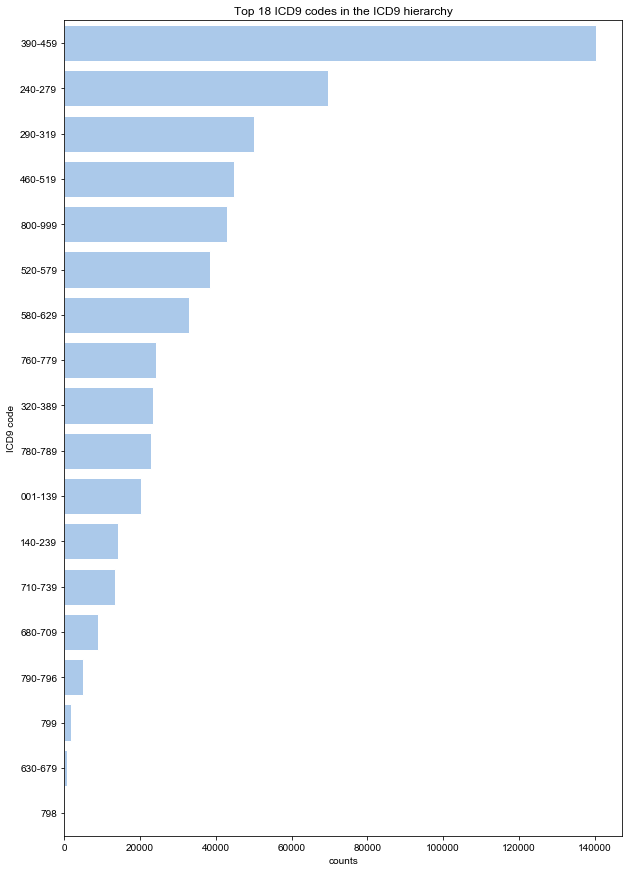

In [17]:
df = pd.DataFrame.from_dict(icd9_codes, orient='index').sort_values(by=0,ascending=False).reset_index()

f, ax = plt.subplots(figsize=(10, 15))

sns.set(style="whitegrid")

sns.set_color_codes("pastel")
sns.barplot(x=0, y='index', data=df,
            label="Total", color="b", orient='h')

ax.set_xlabel('counts')
ax.set_ylabel('ICD9 code')
ax.set_title('Top ' + str(len(icd9_codes)) + ' ICD9 codes in the ICD9 hierarchy')

# Build Training data

In [19]:
#labels = vectorize.vectorize_icd_column(DIAGNOSES_ICD_grp_freq, 'ICD9_GRP', top_codes)
#DIAGNOSES_ICD_grp_freq['LABELS'] = list(labels)

In [21]:
selected_doc=['Discharge summary']
df=df_note_events[df_note_events['CATEGORY'].isin(selected_doc)].groupby('HADM_ID')['TEXT'].apply(lambda x: "{%s}" % ', '.join(x))
df2=pd.DataFrame(df,columns=['TEXT'])


full_df=pd.merge(df2,DIAGNOSES_ICD_grp_freq[['ICD9_GRP']],on='HADM_ID')

In [27]:
full_df['ICD9_GRP'] = full_df.apply(lambda x: ' '.join(x['ICD9_GRP']),1)

In [32]:
full_df = full_df[full_df['ICD9_GRP'] != '']

In [45]:
full_df.iloc[24001:32000].to_csv("../data/full_df_sample4.pkl")

In [34]:
full_df.to_csv("../data/full_df.csv")

# Save the dataset

In [36]:
full_df.to_pickle("../data/full_df.pkl")

In [ ]:
train.head()

In [ ]:
train.to_csv('./train.csv',index=False)
test.to_csv('./test.csv',index=False)

In [ ]:
train.to_pickle("./train.pkl")
test.to_pickle("./test.pkl")